# Test Binning

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import time
from itertools import repeat
import multiprocessing
from joblib import Parallel, delayed
import pandas as pd
from sklearn.metrics import auc

# Bug Fixing

In [26]:
problem_regions = set([
    "chr8_25402079-25402692.npy",
    "chr8_25400686-25401414.npy",
    "chr18_14614837-14615417.npy",
    "chr4_135051533-135052045.npy",
    "chr15_27348617-27349198.npy",
    "chr7_1142401-1144866.npy",
    "chr7_151782043-151782443.npy",
    "chr12_8402962-8403388.npy",
    "chr1_37640513-37642567.npy",
    "chr16_84401461-84401863.npy",
    "chr20_34665376-34666969.npy"
])

NUM_HASHES = 1000

"""
Class for loading all signature matrices and generating an ROC curve as the band size varies.
"""
class signatureMtxs():
    def __init__(self):
        self.signature_mtxs = []

    """
    Load into memory all signature matrices
    """
    def load(self, directory, local_problem_regions = problem_regions, include_length = 0):
        if type(include_length) is int:
            self.include_length = 0
            self.threshold = 0
        else:
            self.include_length = include_length[0]
            self.threshold = include_length[1]

        for file in os.listdir(directory):
            if file in local_problem_regions: continue
            self.signature_mtxs.append(
                np.load( os.path.join(directory,file) )
            )

    def loadMatrix(self, path):
        self.signature_mtxs.append(np.load(path))

    """
    Use banding technique to bin reads by similarity
    """
    def band(self, band_length, matrix_range = None):
        counts = [0 for _ in range(4)]
        if type(matrix_range) is type(range(1)):
            matrix_iterable = self.signature_mtxs[min(matrix_range):max(matrix_range)]
        else:
            matrix_iterable = self.signature_mtxs
        for matrix in matrix_iterable:
            labels = matrix[0,:].astype('int8')
            signature_matrix = matrix[1:,:]
            for i, count in enumerate(
                self.tprSignatureMatrix(signature_matrix, band_length, labels, wantAdjacencyMatrix = False)
            ):
                counts[i] += count
        return counts

    """
    Generate TPR and FPR for a given signature matrix, band length, and label list
    Returns [test_pos, tot_pos, test_neg, tot_neg]
    """
    def tprSignatureMatrix(self, signature_matrix, band_length, labels, wantAdjacencyMatrix = False):
        def connectBucket(bucket, adjacencyMatrix):
            for i in range(len(bucket)-1):
                for j in range(i+1, len(bucket)):
                    # Include length filtering at this step
                    # TODO this code will actually break lol
                    if self.include_length == 1 and (abs(len(i) - len(j)) > self.threshold): continue
                    if self.include_length == 2 and ( (len(i) - len(j)) / max(len(i), len(j)) > self.threshold): continue
                    

                    adjacencyMatrix[bucket[i],bucket[j]] = True
                    adjacencyMatrix[bucket[j],bucket[i]] = True
            return adjacencyMatrix

        firstOcc = np.argmax(labels>1)
        adjacencyMatrix = np.zeros((len(labels), len(labels)))

        for i in range(signature_matrix.shape[0]//band_length):
            buckets = defaultdict(list[int])
            startBucket = i*band_length
            endBucket = (i+1)*band_length
            for j in range(signature_matrix.shape[1]):
                buckets[signature_matrix[startBucket:endBucket, j].tobytes()].append(j)
            for bucket in buckets.values():
                adjacencyMatrix = connectBucket(bucket, adjacencyMatrix)

        if wantAdjacencyMatrix:
            return self.tpr_fpr(len(labels), firstOcc, adjacencyMatrix), adjacencyMatrix

        return self.tpr_fpr(len(labels), firstOcc, adjacencyMatrix)

    def tpr_fpr(self, n, firstOcc, adjacencyMatrix):
        trueMask = np.zeros((n , n), dtype = bool)
        trueMask[:firstOcc, :firstOcc] = 1
        trueMask[firstOcc:, firstOcc:] = 1

        true_pos = int(np.sum(adjacencyMatrix, where = trueMask)/2)
        tot_pos = int((np.sum(trueMask) - n)/2)
        false_pos = int(np.sum(adjacencyMatrix, where = ~trueMask)/2)
        tot_neg = int(np.sum(~trueMask)/2)

        return true_pos, tot_pos, false_pos, tot_neg

"""
Load class with correct input matrices
"""
def loadFilter(path, include_length):
    if path == "euclidean":
        filter_dir = "../../../output/signatureMtxs_20bp/euclidean/1000,21,1,1"
    elif path == "sketch":
        filter_dir = "../../../output/signatureMtxs_20bp/sketch/1000,21,1"
    elif path == "minHash":
        filter_dir = "../../../output/signatureMtxs_20bp/minHash/1000,21,1"
    else:
        filter_dir = path

    filter_test = signatureMtxs()
    start_time = time.time()
    filter_test.load(filter_dir, include_length = include_length)
    load_time = time.time()
    return filter_test, load_time - start_time

"""
Call band function on filters. Needed so we can parallelize
"""
def bandFunction(filter_test, band_size, matrix_range = None):
    output = filter_test.band(band_size, matrix_range)
    return output

"""
Parallelize calling band function on all band sizes and regions
"""
def bandTest(filter_test, band_sizes = range(1,200), matrix_range = None):
    inputs = zip(repeat(filter_test), band_sizes, repeat(matrix_range))
    num_cores = multiprocessing.cpu_count()

    print("Running Parallel Step")
    start = time.time()
    outputs = Parallel(n_jobs=num_cores, verbose=0)(delayed(bandFunction)(i, j, k) for i, j, k  in inputs)
    end = time.time()
    print("Compute Time:\t", end-start)
    
    tprs = []
    fprs = []
    for a, b, c, d in outputs:
        tprs.append(a/b)
        fprs.append(c/d)
    return outputs, band_sizes, tprs, fprs

"""
Calls object generations, loading, and testing functions
"""
def filterBandTests(path, band_sizes = range(1,200), matrix_range = None, include_length = 0):
    print(path)
    filter_test, load_time = loadFilter(path, include_length)
    print("Load Time:\t", round(load_time, 2))

    outputs, band_sizes, tprs, fprs = bandTest(filter_test, band_sizes = band_sizes, matrix_range = matrix_range)

    return outputs, band_sizes, tprs, fprs

"""
Wraps caller function to return data in pandas dataframe for ease of use
"""
def dataToPandas(filter_type, read_in = True, band_sizes = range(1,200), matrix_range = None, include_length = 0):
    output_path = "../../../output/analysis"
    save_path = os.path.join(output_path, f"{filter_type}.tsv")

    if read_in:
        try:
            df = pd.read_csv(save_path, sep="\t")
            return df
        except:
            print(f"File not found {save_path}")
            print("Running Band Tests")
    print("Running Tests")
    band_test_output = filterBandTests(filter_type, band_sizes=band_sizes, matrix_range = matrix_range, include_length = include_length)
    outputs, bands, tprs, fprs = band_test_output
    found_pos, max_pos, found_err, max_err = zip(*outputs)
    columns = {
        "found_pos": found_pos,
        "max_pos":max_pos,
        "found_err":found_err,
        "max_err":max_err,
        "band_sizes":bands,
        "tpr":tprs,
        "fpr":fprs
    }
    print("Generating Data Frame")
    df = pd.DataFrame.from_dict(columns)
    df.to_csv(save_path, sep="\t", index=False, header=True)

    return df


## Run Filters

## Plot ROC Curve

In [21]:
"""
Plot the ROC curve
"""
def plotROC(df, title = "ROC Curve"):
    bands = df["band_sizes"]
    tprs = df["tpr"]
    fprs = df["fpr"]

    #area_under_curve = auc(fprs, tprs)

    # Plot the ROC curve
    fig, ax = plt.subplots()

    plt.scatter(fprs, tprs, c = bands, marker = ".")
    num_labels = min(10, len(bands))
    scale = int(len(bands)//num_labels)
    for i in range(num_labels):
        index = i*scale
        ax.text(fprs[index], tprs[index]+0.05, bands[index])

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc = "lower right")

    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


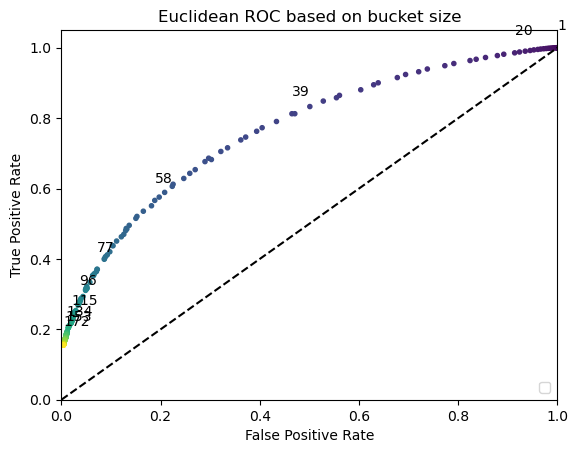

In [22]:
title = "Euclidean ROC based on bucket size"
plotROC(euclidean_df, title)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


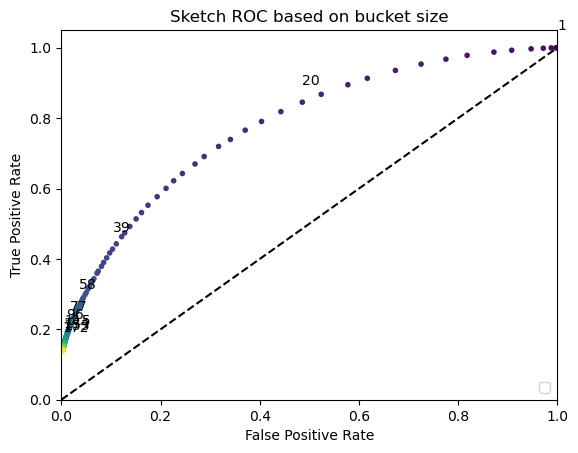

In [23]:
title = "Sketch ROC based on bucket size"
plotROC(sketch_df, title)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


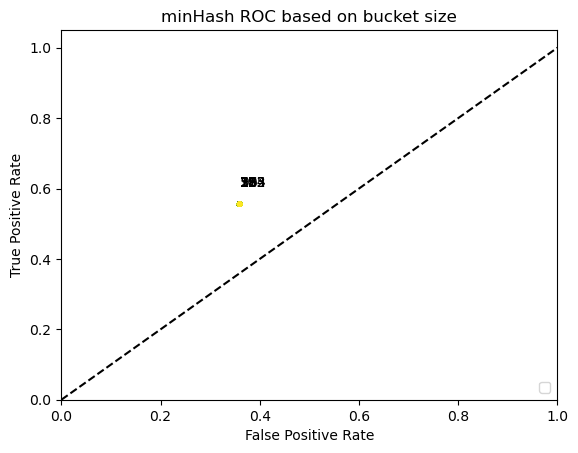

In [24]:
title = "minHash ROC based on bucket size"
plotROC(minHash_df, title)

### Why is minHash all stacked in one place?


This is really confusing for me. I'm using the exact same code for all three groups so there shouldn't be any problems in how we are counting tpr and fprs. The only difference is the signature matrices that I'm loading in correspond to the minHash output as opposed to the others. But when analyzing the matrices below they don't all look the same or have overly large groups of patterns. I'm really confused how to even diagnose further.

I will test the minHash filter on a smaller set and take a look at the results directly, from computing the TPR/FPR on small samples and see if this holds from the test_filters script.

This is really confusing me.

In [9]:
def show_problems(matrix):
    total_dif = 0
    n = matrix.shape[1]
    difs = [[0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            dif = sum(matrix[:,i] - matrix[:,j])
            if dif == 0 and not np.all(matrix[:,i] == matrix[:,j]):
                print("Weirdness reads:", i, j)
            difs[i][j] = dif
            total_dif += abs(dif)
    print(total_dif)

    vmin = np.min(difs)
    vmax = np.max(difs)
    print(vmin, vmax)
    plt.imshow(difs, cmap='viridis', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar()
    cbar.set_label('Value')
    plt.show()

In [10]:
minHash_dir = "/data/wford/sv_merge/output/signatureMtxs/minHash/1000,20,40"
minHash_test = signatureMtxs()
minHash_test.load(minHash_dir)

52312.0
-1000.0 1000.0


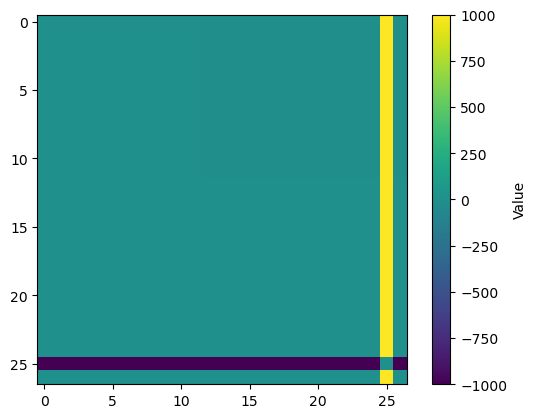

156.0
-1.0 1.0


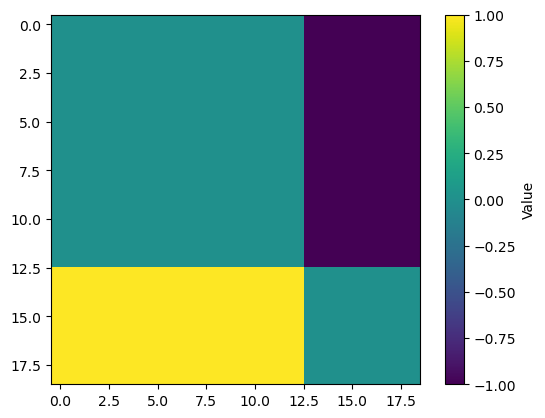

90.0
-1.0 1.0


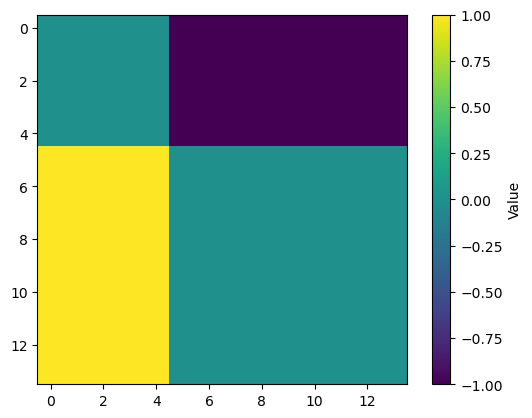

38150.0
-1001.0 1001.0


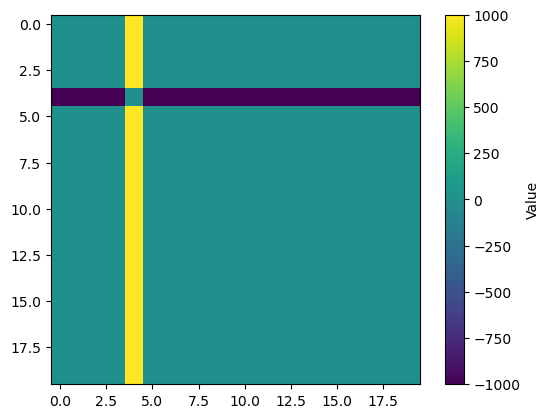

242.0
-1.0 1.0


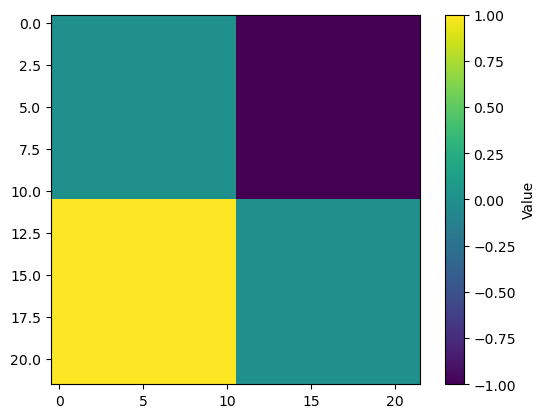

120.0
-1.0 1.0


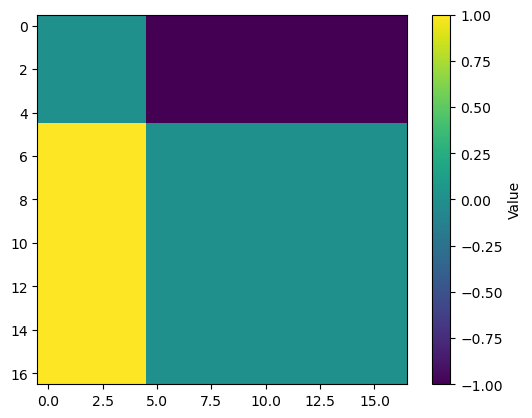

988182.0
-26001.0 26001.0


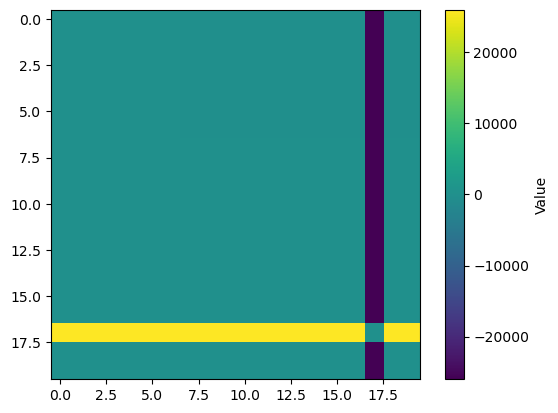

1760236.0
-11001.0 11001.0


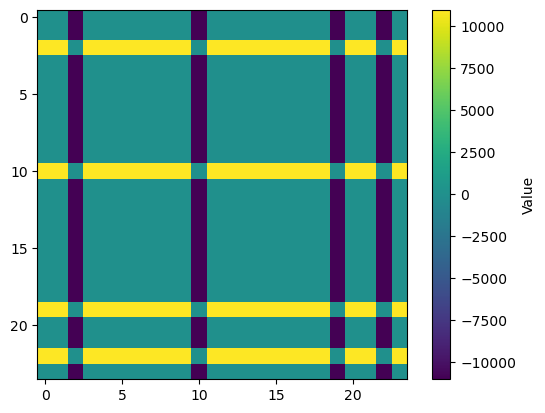

126.0
-1.0 1.0


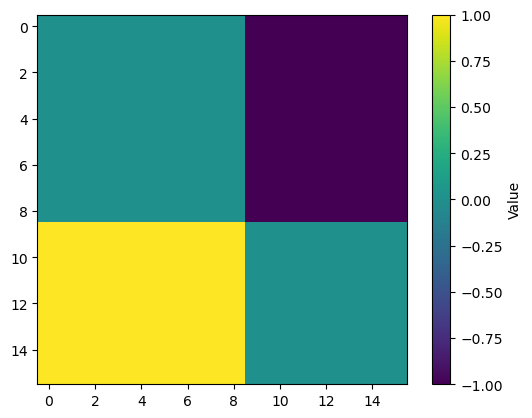

616100.0
-22001.0 22001.0


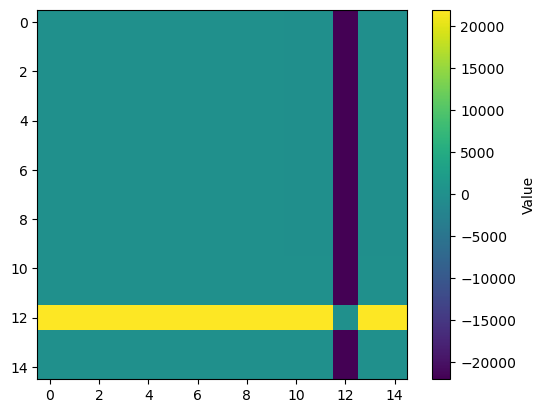

In [11]:
for i in range(10):
    show_problems(minHash_test.signature_mtxs[i])

I think the weirdness has to do with the differences of 1 vs 1,000 vs 20,000. This indicates that almost all of the buckets are the exact same for almost all of the reads. Then randomly it looks like a read is somehow so different than the rest that it has almost no buckets similar. This merits further investigating.

#### minHash with large band size

In [26]:
minHash_df_ranges = []
for i in range(10):
    start_region = i * 100
    end_region =  (i+1) * 100
    minHash_df_ranges.append(dataToPandas("minHash", read_in = False, band_sizes = range(100,501,100), matrix_range = range(start_region, end_region)))

minHash
Load Time:	 1.52


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   20.9s finished


Compute Time:	 20.880352020263672
minHash
Load Time:	 1.52


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.6s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   14.9s finished


Compute Time:	 14.921144008636475
minHash
Load Time:	 1.2


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   15.1s finished


Compute Time:	 15.065966844558716
minHash
Load Time:	 1.2


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   15.0s finished


Compute Time:	 15.013811588287354
minHash
Load Time:	 1.19


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    7.3s remaining:   11.0s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   15.6s finished


Compute Time:	 15.637235641479492
minHash
Load Time:	 1.19


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.5s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   15.1s finished


Compute Time:	 15.129993677139282
minHash
Load Time:	 1.2


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.6s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   14.9s finished


Compute Time:	 14.91419792175293
minHash
Load Time:	 1.19


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.4s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   15.1s finished


Compute Time:	 15.087099552154541
minHash
Load Time:	 1.19


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.3s
[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   15.2s finished


Compute Time:	 15.218103647232056
minHash
Load Time:	 1.18


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   2 out of   5 | elapsed:    6.7s remaining:   10.1s


Compute Time:	 14.29979920387268


[Parallel(n_jobs=128)]: Done   5 out of   5 | elapsed:   14.3s finished


In [27]:
minHash_df_ranges

[   found_pos  max_pos  found_err  max_err  band_sizes       tpr      fpr
 0       6305     7188       5558     7224         100  0.877156  0.76938
 1       6305     7188       5558     7224         200  0.877156  0.76938
 2       6305     7188       5558     7224         300  0.877156  0.76938
 3       6305     7188       5558     7224         400  0.877156  0.76938
 4       6305     7188       5558     7224         500  0.877156  0.76938,
    found_pos  max_pos  found_err  max_err  band_sizes       tpr       fpr
 0       7388     8050       7021     7986         100  0.917764  0.879164
 1       7388     8050       7021     7986         200  0.917764  0.879164
 2       7388     8050       7021     7986         300  0.917764  0.879164
 3       7388     8050       7021     7986         400  0.917764  0.879164
 4       7388     8050       7021     7986         500  0.917764  0.879164,
    found_pos  max_pos  found_err  max_err  band_sizes       tpr       fpr
 0       6950     7857       

In [28]:
tiny_minHash_df_ranges = []
for i in range(10):
    start_region = i * 100
    end_region =  (i+1) * 100
    tiny_minHash_df_ranges.append(dataToPandas("minHash", read_in = False, band_sizes = range(1,2), matrix_range = range(start_region, end_region)))

minHash
Load Time:	 1.21


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.4395036697387695
minHash
Load Time:	 1.53


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.464499473571777
minHash
Load Time:	 1.52


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.378319263458252
minHash
Load Time:	 1.52


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.446295499801636
minHash
Load Time:	 1.51


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.169932842254639
minHash
Load Time:	 1.5


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.448399305343628
minHash
Load Time:	 1.51


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.120500087738037
minHash
Load Time:	 1.51


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 6.9693169593811035
minHash
Load Time:	 1.52


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.234246730804443
minHash
Load Time:	 1.52


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Compute Time:	 7.7334558963775635


In [29]:
tiny_minHash_df_ranges

[   found_pos  max_pos  found_err  max_err  band_sizes       tpr      fpr
 0       6305     7188       5558     7224           1  0.877156  0.76938,
    found_pos  max_pos  found_err  max_err  band_sizes       tpr       fpr
 0       7388     8050       7021     7986           1  0.917764  0.879164,
    found_pos  max_pos  found_err  max_err  band_sizes       tpr       fpr
 0       6950     7857       6259     7799           1  0.884562  0.802539,
    found_pos  max_pos  found_err  max_err  band_sizes       tpr       fpr
 0       7026     7681       6765     7759           1  0.914725  0.871891,
    found_pos  max_pos  found_err  max_err  band_sizes       tpr       fpr
 0       6977     7984       6306     7947           1  0.873873  0.793507,
    found_pos  max_pos  found_err  max_err  band_sizes       tpr      fpr
 0       6632     7525       6341     7557           1  0.881329  0.83909,
    found_pos  max_pos  found_err  max_err  band_sizes      tpr       fpr
 0       6060     6970  

In [30]:
minHash_df

,found_pos,max_pos,found_err,max_err,band_sizes,tpr,fpr
0,1009629,1133473,918640,1130015,1,0.890739,0.812945
1,1009629,1133473,918640,1130015,2,0.890739,0.812945
2,1009629,1133473,918640,1130015,3,0.890739,0.812945
3,1009629,1133473,918640,1130015,4,0.890739,0.812945
4,1009629,1133473,918640,1130015,5,0.890739,0.812945
...,...,...,...,...,...,...,...
194,1009629,1133473,918640,1130015,195,0.890739,0.812945
195,1009629,1133473,918640,1130015,196,0.890739,0.812945
196,1009629,1133473,918640,1130015,197,0.890739,0.812945
197,1009629,1133473,918640,1130015,198,0.890739,0.812945


Repetitive Regions:
```
chr16	5484407	5484741
chr6	30332563	30332851
```

Non Repetitive:
```
chr16	14396657	14397075
chr6	23559543	23559857
```

`
samtools view -bh gs://fc-28761d6c-5677-4941-86e7-6e42b59a27f4/willard/HG002/HG002_haplotagged.bam\
      chr16:5484407-5484741 > repetitive.bam`

In [12]:
repetitive_paths = ["chr16_5484207-5484941.npy", "chr6_30332363-30333051.npy"]
non_repetitive_paths = ["chr16_14396457-14397275.npy", "chr6_23559343-23560057.npy"]

def getAdjacencyMatrix(path, matrix_path, bands = range(1,200, 40)):
    euclidean_path = "../../../output/signatureMtxs/euclidean/1000,20,5,1"
    sketch_path = "../../../output/signatureMtxs/sketch/1000,20,40"

    if path == "euclidean":
        path = euclidean_path
    elif path == "sketch":
        path = sketch_path

    filter_test = signatureMtxs()
    filter_test.loadMatrix(os.path.join(path, matrix_path))
    
    matrix = filter_test.signature_mtxs[-1]
    labels = matrix[0,:].astype('int8')
    signature_matrix = matrix[1:,:]

    outputs = []
    adjacency_matrices = []
    for i in bands:
        output, adjacency_matrix = filter_test.tprSignatureMatrix(signature_matrix, i, labels, wantAdjacencyMatrix=True)
        outputs.append(output)
        adjacency_matrices.append(adjacency_matrix)
    return outputs, adjacency_matrices

"""
def plotAdjacencyMatrices(adj_matrices, ):
    def plotAdjacencyMatrix(adjacencyMatrix):
        n = adjacencyMatrix.shape[0]
        plt.imshow(adjacencyMatrix, 
                   cmap = 'binary_r', 
                   interpolation='nearest', 
                   vmin=0, vmax=1
        )
        plt.title(f"Adjacency Matrix, ")
        plt.xticks(np.arange(n), np.arange(1, n + 1))
        plt.yticks(np.arange(n), np.arange(1, n + 1))

        plt.tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False)
        plt.xlabel(f"White in pos i,j indicates i connects j")
        for x in self.firstOcc[1:]:
            plt.axhline(x - 0.5, color='red', linestyle='-', linewidth=2)
            plt.axvline(x - 0.5, color='red', linestyle='-', linewidth=2)
    
    for matrix in adj_matrices:
        plotAdjacencyMatrix(matrix, )
"""


'\ndef plotAdjacencyMatrices(adj_matrices, ):\n    def plotAdjacencyMatrix(adjacencyMatrix):\n        n = adjacencyMatrix.shape[0]\n        plt.imshow(adjacencyMatrix, \n                   cmap = \'binary_r\', \n                   interpolation=\'nearest\', \n                   vmin=0, vmax=1\n        )\n        plt.title(f"Adjacency Matrix, ")\n        plt.xticks(np.arange(n), np.arange(1, n + 1))\n        plt.yticks(np.arange(n), np.arange(1, n + 1))\n\n        plt.tick_params(axis=\'x\', top=True, bottom=False, labeltop=True, labelbottom=False)\n        plt.xlabel(f"White in pos i,j indicates i connects j")\n        for x in self.firstOcc[1:]:\n            plt.axhline(x - 0.5, color=\'red\', linestyle=\'-\', linewidth=2)\n            plt.axvline(x - 0.5, color=\'red\', linestyle=\'-\', linewidth=2)\n    \n    for matrix in adj_matrices:\n        plotAdjacencyMatrix(matrix, )\n'

### Euclidean

In [13]:
bands = list(range(1,200, 1))

#### Repetitive Regions

In [14]:
repetitive_outputs, repetitive_adjacenecy_matrices = getAdjacencyMatrix("euclidean", repetitive_paths[0], bands)
plotROC(0,0, bands=bands, outputs=repetitive_outputs)

TypeError: plotROC() got an unexpected keyword argument 'bands'

In [15]:
repetitive_outputs, repetitive_adjacenecy_matrices = getAdjacencyMatrix("euclidean", repetitive_paths[1], bands)
plotROC(0,0, bands=bands, outputs=repetitive_outputs)

TypeError: plotROC() got an unexpected keyword argument 'bands'

#### Non-Repetitive Regions

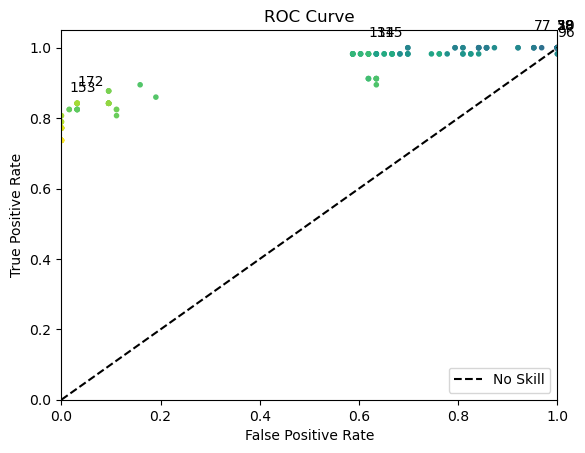

In [19]:
non_repetitive_outputs, non_repetitive_adjacenecy_matrices = getAdjacencyMatrix("euclidean", non_repetitive_paths[0], bands)
plotROC(0,0, bands= bands, outputs=non_repetitive_outputs)

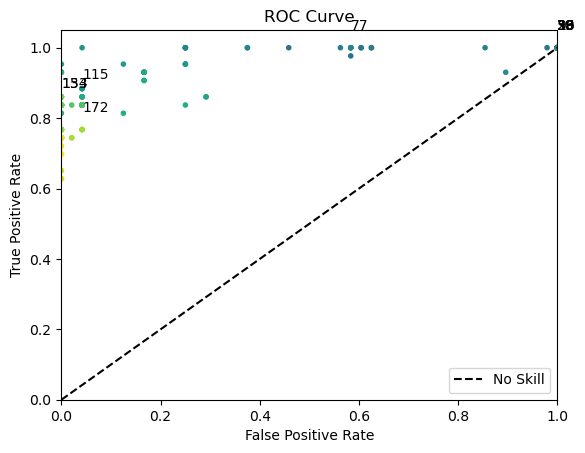

In [20]:
non_repetitive_outputs, non_repetitive_adjacenecy_matrices = getAdjacencyMatrix("euclidean", non_repetitive_paths[1], bands)
plotROC(0,0, bands= bands, outputs=non_repetitive_outputs)

### Sketch

#### Repetitive Regions

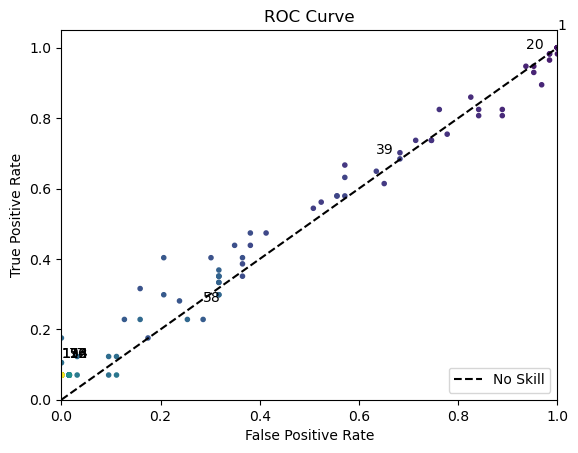

In [21]:
repetitive_outputs, repetitive_adjacenecy_matrices = getAdjacencyMatrix("sketch", repetitive_paths[0], bands)
plotROC(0,0, bands=bands, outputs=repetitive_outputs)

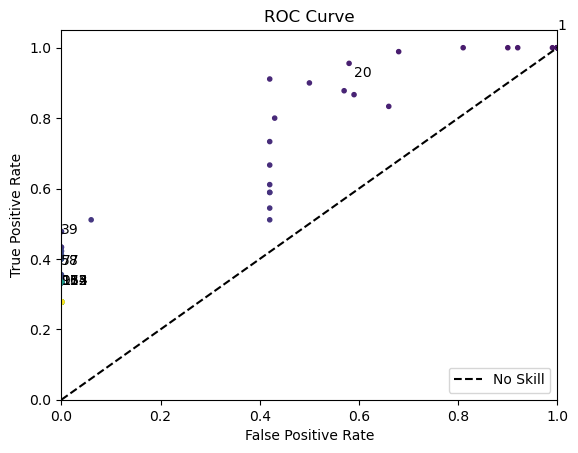

In [22]:
repetitive_outputs, repetitive_adjacenecy_matrices = getAdjacencyMatrix("sketch", repetitive_paths[1], bands)
plotROC(0,0, bands=bands, outputs=repetitive_outputs)

#### Non-Repetitive Regions

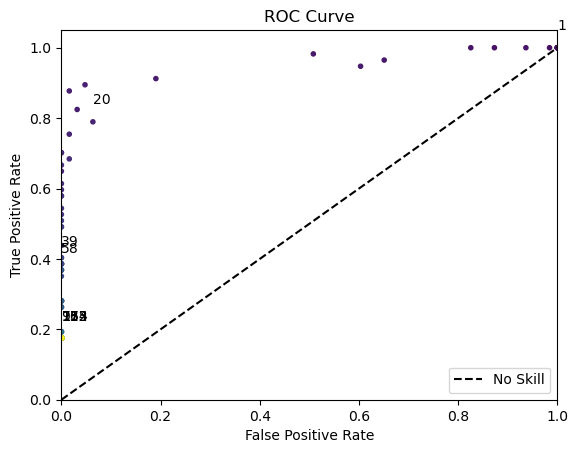

In [23]:
non_repetitive_outputs, non_repetitive_adjacenecy_matrices = getAdjacencyMatrix("sketch", non_repetitive_paths[0], bands)
plotROC(0,0, bands= bands, outputs=non_repetitive_outputs)

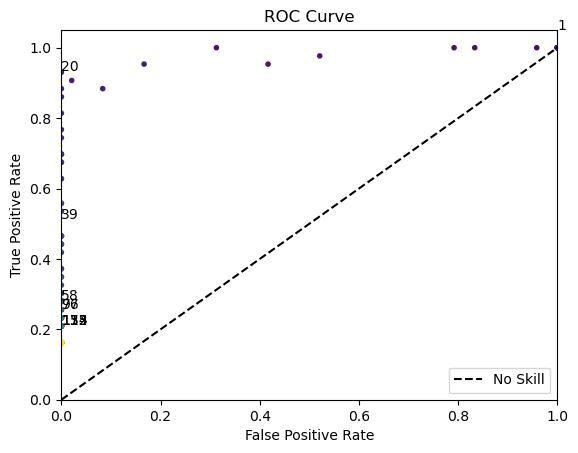

In [24]:
non_repetitive_outputs, non_repetitive_adjacenecy_matrices = getAdjacencyMatrix("sketch", non_repetitive_paths[1], bands)
plotROC(0,0, bands= bands, outputs=non_repetitive_outputs)

# Load Dif Band Sizes

In [2]:
"""
Iterate over all band sizes for a single region. Called in parallel over every region at once.
"""
def test_bands(signature_matrix_directory, file, band_sizes, include_length = False):
    signature_matrix = np.load(os.path.join(signature_matrix_directory, file))
    labels = signature_matrix[0,:].astype('int8')
    signature_matrix = signature_matrix[1:,:]

    if include_length:
        length_adjacency_matrix = np.load(os.path.join(include_length, file))
    else:
        length_adjacency_matrix = False

    counts = np.zeros((4, len(band_sizes)), dtype = int)
    for band_size in band_sizes:
        counts[:,band_size-1] = tprSignatureMatrix(signature_matrix, band_size, labels, length_adjacency_matrix)
    return counts

"""
Generate TPR and FPR for a given signature matrix, band length, and label list
Returns [test_pos, tot_pos, test_neg, tot_neg]
"""
def tprSignatureMatrix(signature_matrix, band_length, labels, length_adjacency_matrix = False):
    def connectBucket(bucket, adjacencyMatrix):
        for i in range(len(bucket)-1):
            for j in range(i+1, len(bucket)):
                # TODO Include length filtering at this step
                    #if include_length == 1 and (abs(len(i) - len(j)) > self.threshold): continue
                    #if include_length == 2 and ( (len(i) - len(j)) / max(len(i), len(j)) > self.threshold): continue

                adjacencyMatrix[bucket[i],bucket[j]] = True
                adjacencyMatrix[bucket[j],bucket[i]] = True
        return adjacencyMatrix

    firstOcc = np.argmax(labels>1)
    adjacencyMatrix = np.zeros((len(labels), len(labels)))

    for i in range(signature_matrix.shape[0]//band_length):
        buckets = defaultdict(list[int])
        startBucket = i*band_length
        endBucket = (i+1)*band_length
        for j in range(signature_matrix.shape[1]):
            buckets[signature_matrix[startBucket:endBucket, j].tobytes()].append(j)
        for bucket in buckets.values():
            adjacencyMatrix = connectBucket(bucket, adjacencyMatrix)

    # Remove connections forbidden by length_adjacency_matrix
    if type(length_adjacency_matrix) is np.ndarray:
        n = len(adjacencyMatrix)
        for i in range(n-1):
            for j in range(i+1, n):
                if adjacencyMatrix[i,j] is True and length_adjacency_matrix[i,j] is False:
                    adjacencyMatrix[i,j] = False
                    adjacencyMatrix[j,i] = False

    return tpr_fpr(len(labels), firstOcc, adjacencyMatrix)

"""
Generate true positive rate and false positive rate for a given adjacency matrix
"""
def tpr_fpr(n, firstOcc, adjacencyMatrix):
    trueMask = np.zeros((n , n), dtype = bool)
    trueMask[:firstOcc, :firstOcc] = 1
    trueMask[firstOcc:, firstOcc:] = 1

    true_pos = int(np.sum(adjacencyMatrix, where = trueMask)/2)
    tot_pos = int((np.sum(trueMask) - n)/2)
    false_pos = int(np.sum(adjacencyMatrix, where = ~trueMask)/2)
    tot_neg = int(np.sum(~trueMask)/2)

    local_counts = np.array([true_pos, tot_pos, false_pos, tot_neg])

    return local_counts

def parallel_regions(signature_matrix_directory, band_sizes = range(1, 500), include_length = False):
    numpy_files = os.listdir(signature_matrix_directory)

    inputs = zip(repeat(signature_matrix_directory), numpy_files, repeat(band_sizes), repeat(include_length))
    num_cores = multiprocessing.cpu_count()

    print("Running Parallel Step")
    start = time.time()
    outputs = Parallel(n_jobs=num_cores, verbose=1)(delayed(test_bands)(i, j, k, l) for i, j, k, l  in inputs)
    print("Total time\t:", time.time() - start)

    counts = outputs[0]
    for output in outputs[1:]:
        counts += output
    return counts

In [3]:
euclidean_signature_matrix_directory = "../../../output/signatureMtxs_20bp/euclidean/1000,21,16,1"
euclidean_counts = parallel_regions(euclidean_signature_matrix_directory)


Running Parallel Step


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


[Parallel(n_jobs=128)]: Done 194 tasks      | elapsed:    2.5s
[Parallel(n_jobs=128)]: Done 829 tasks      | elapsed:    7.0s
[Parallel(n_jobs=128)]: Done 1378 tasks      | elapsed:   10.1s
[Parallel(n_jobs=128)]: Done 1928 tasks      | elapsed:   13.6s
[Parallel(n_jobs=128)]: Done 2578 tasks      | elapsed:   17.8s
[Parallel(n_jobs=128)]: Done 3328 tasks      | elapsed:   22.5s
[Parallel(n_jobs=128)]: Done 4178 tasks      | elapsed:   27.9s
[Parallel(n_jobs=128)]: Done 5128 tasks      | elapsed:   34.0s
[Parallel(n_jobs=128)]: Done 6178 tasks      | elapsed:   40.6s
[Parallel(n_jobs=128)]: Done 7328 tasks      | elapsed:   48.2s
[Parallel(n_jobs=128)]: Done 8578 tasks      | elapsed:   56.1s
[Parallel(n_jobs=128)]: Done 9928 tasks      | elapsed:  1.1min
[Parallel(n_jobs=128)]: Done 11378 tasks      | elapsed:  1.2min
[Parallel(n_jobs=128)]: Done 12928 tasks      | elapsed:  1.4min
[Parallel(n_jobs=128)]: Done 14578 tasks      | elapsed:  1.6min
[Parallel(n_jobs=128)]: Done 16328 task

Total time	: 200.10146737098694


[Parallel(n_jobs=128)]: Done 30947 out of 30947 | elapsed:  3.3min finished


In [4]:
sketch_signature_matrix_directory = "../../../output/signatureMtxs_20bp/sketch/1000,21,1"
sketch_counts = parallel_regions(sketch_signature_matrix_directory)

[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Running Parallel Step


[Parallel(n_jobs=128)]: Done 194 tasks      | elapsed:    1.8s
[Parallel(n_jobs=128)]: Done 831 tasks      | elapsed:    6.3s
[Parallel(n_jobs=128)]: Done 1378 tasks      | elapsed:    9.4s
[Parallel(n_jobs=128)]: Done 1928 tasks      | elapsed:   13.0s
[Parallel(n_jobs=128)]: Done 2578 tasks      | elapsed:   17.1s
[Parallel(n_jobs=128)]: Done 3328 tasks      | elapsed:   21.9s
[Parallel(n_jobs=128)]: Done 4178 tasks      | elapsed:   27.3s
[Parallel(n_jobs=128)]: Done 5128 tasks      | elapsed:   33.5s
[Parallel(n_jobs=128)]: Done 6178 tasks      | elapsed:   40.0s
[Parallel(n_jobs=128)]: Done 7328 tasks      | elapsed:   47.7s
[Parallel(n_jobs=128)]: Done 8578 tasks      | elapsed:   55.6s
[Parallel(n_jobs=128)]: Done 9928 tasks      | elapsed:  1.1min
[Parallel(n_jobs=128)]: Done 11378 tasks      | elapsed:  1.2min
[Parallel(n_jobs=128)]: Done 12928 tasks      | elapsed:  1.4min
[Parallel(n_jobs=128)]: Done 14578 tasks      | elapsed:  1.6min
[Parallel(n_jobs=128)]: Done 16328 task

Total time	: 199.8843479156494


[Parallel(n_jobs=128)]: Done 30947 out of 30947 | elapsed:  3.3min finished


In [20]:
minHash_signature_matrix_directory = "../../../output/signatureMtxs_20bp/minHash/1000,21,1"
minHash_counts = parallel_regions(minHash_signature_matrix_directory)

[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Running Parallel Step


[Parallel(n_jobs=128)]: Done 194 tasks      | elapsed:    1.2s
[Parallel(n_jobs=128)]: Done 832 tasks      | elapsed:    3.8s
[Parallel(n_jobs=128)]: Done 1506 tasks      | elapsed:    6.1s
[Parallel(n_jobs=128)]: Done 2056 tasks      | elapsed:    8.2s
[Parallel(n_jobs=128)]: Done 2706 tasks      | elapsed:   10.7s
[Parallel(n_jobs=128)]: Done 3456 tasks      | elapsed:   13.5s
[Parallel(n_jobs=128)]: Done 4306 tasks      | elapsed:   16.7s
[Parallel(n_jobs=128)]: Done 5256 tasks      | elapsed:   20.4s
[Parallel(n_jobs=128)]: Done 6306 tasks      | elapsed:   24.3s
[Parallel(n_jobs=128)]: Done 7456 tasks      | elapsed:   28.7s
[Parallel(n_jobs=128)]: Done 8706 tasks      | elapsed:   33.5s
[Parallel(n_jobs=128)]: Done 10056 tasks      | elapsed:   38.6s
[Parallel(n_jobs=128)]: Done 11506 tasks      | elapsed:   44.2s
[Parallel(n_jobs=128)]: Done 13056 tasks      | elapsed:   50.1s
[Parallel(n_jobs=128)]: Done 14706 tasks      | elapsed:   56.5s
[Parallel(n_jobs=128)]: Done 16456 tas

Total time	: 118.99474930763245


[Parallel(n_jobs=128)]: Done 31093 out of 31093 | elapsed:  2.0min finished


In [5]:
def numpy_counts_to_pandas(array):
    df = pd.DataFrame()
    df["true_pos"] = array[0,:]
    df["tot_pos"] = array[1,:]
    df["false_pos"] = array[2,:]
    df["tot_neg"] = array[3,:]

    df["tpr"] = df["true_pos"] / df["tot_pos"]
    df["fpr"] = df["false_pos"] / df["tot_neg"]
    df["band_size"] = range(1,500)

    return df

"""
Plot the ROC curve
"""
def plotROC(df, title = "ROC Curve"):
    bands = df["band_size"]
    tprs = df["tpr"]
    fprs = df["fpr"]

    #area_under_curve = auc(fprs, tprs)

    # Plot the ROC curve
    fig, ax = plt.subplots()

    plt.scatter(fprs, tprs, c = bands, marker = ".")
    num_labels = min(10, len(bands))
    scale = int(len(bands)//num_labels)
    for i in range(num_labels):
        index = i*scale
        ax.text(fprs[index], tprs[index]+0.05, bands[index])

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc = "lower right")

    plt.show()

In [6]:
#minHash_df = numpy_counts_to_pandas(minHash_counts)
euclidean_df = numpy_counts_to_pandas(euclidean_counts)
sketch_df = numpy_counts_to_pandas(sketch_counts)

In [7]:
#plotROC(minHash_df, "ROC Curve minHash")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


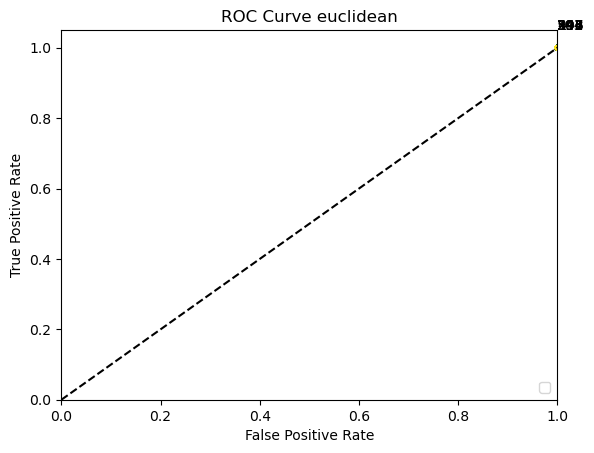

In [11]:
plotROC(euclidean_df, "ROC Curve euclidean")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


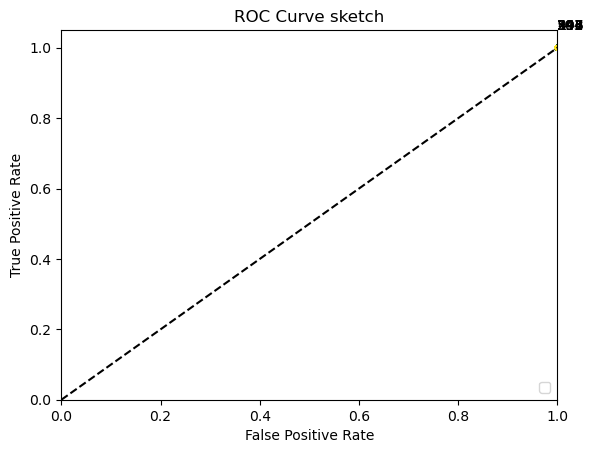

In [9]:
plotROC(sketch_df, "ROC Curve sketch")

## Euclidean by Band Size

In [10]:
euclidean_dir = "../../../output/signatureMtxs_20bp/euclidean"

euclidean_dfs_by_bin_size = []

for bin_size_path in os.listdir(euclidean_dir):
    bin_size_counts = parallel_regions(os.path.join(euclidean_dir, bin_size_path))
    euclidean_dfs_by_bin_size.append(numpy_counts_to_pandas(bin_size_counts))

[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


Running Parallel Step


[Parallel(n_jobs=128)]: Done 194 tasks      | elapsed:    1.8s
[Parallel(n_jobs=128)]: Done 831 tasks      | elapsed:    6.2s
[Parallel(n_jobs=128)]: Done 1378 tasks      | elapsed:    9.4s
[Parallel(n_jobs=128)]: Done 1928 tasks      | elapsed:   13.0s
[Parallel(n_jobs=128)]: Done 2578 tasks      | elapsed:   17.2s
[Parallel(n_jobs=128)]: Done 3328 tasks      | elapsed:   21.9s
[Parallel(n_jobs=128)]: Done 4178 tasks      | elapsed:   27.3s
[Parallel(n_jobs=128)]: Done 5128 tasks      | elapsed:   33.5s
[Parallel(n_jobs=128)]: Done 6178 tasks      | elapsed:   40.1s


KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


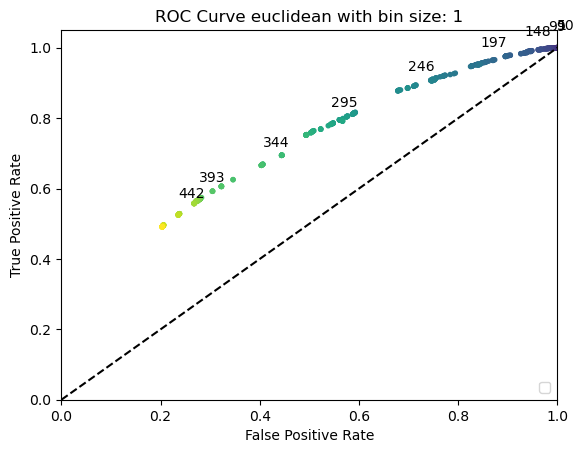

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


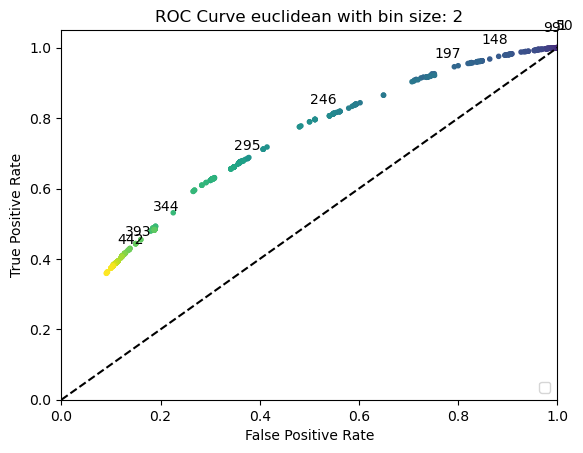

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


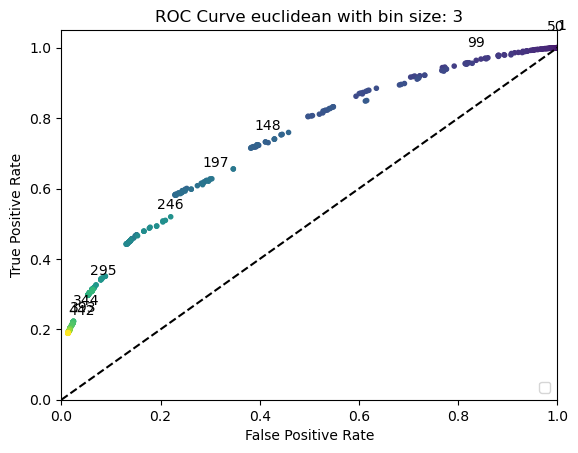

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


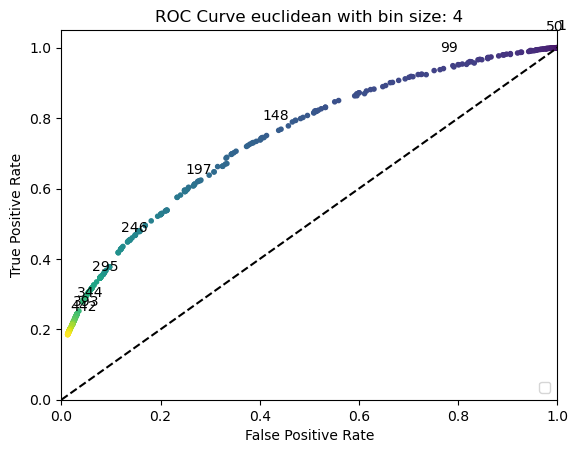

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


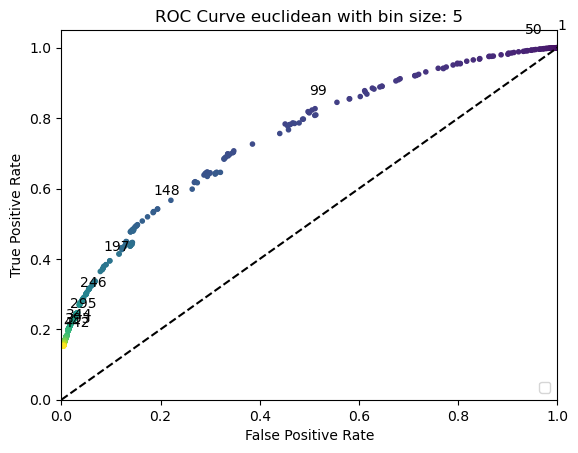

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


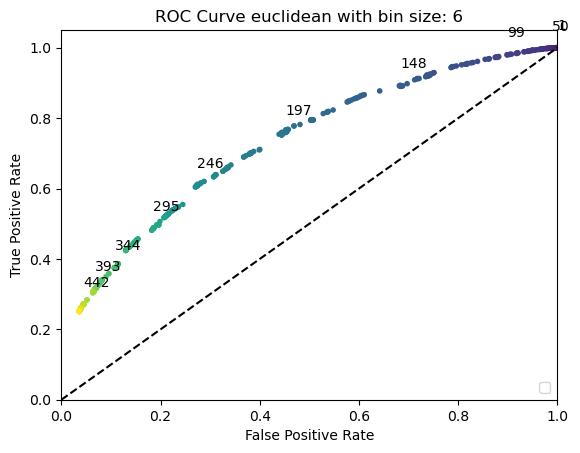

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


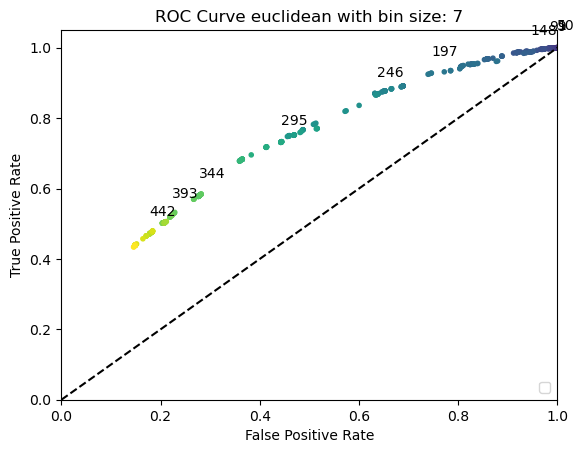

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


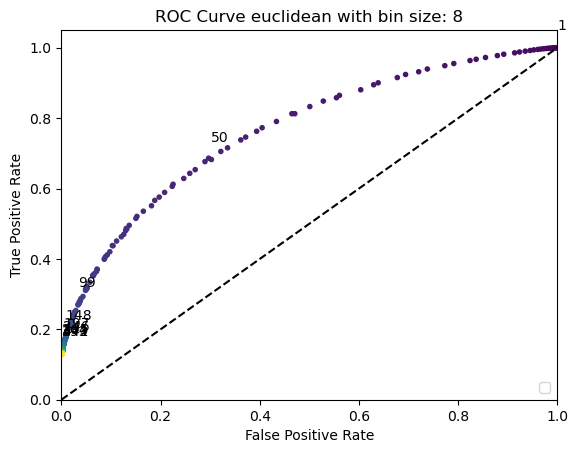

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


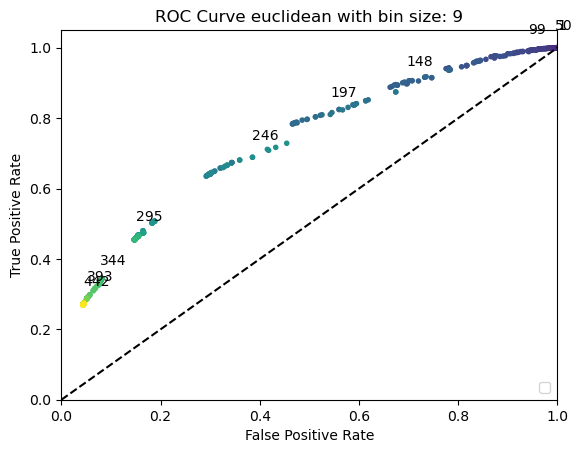

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


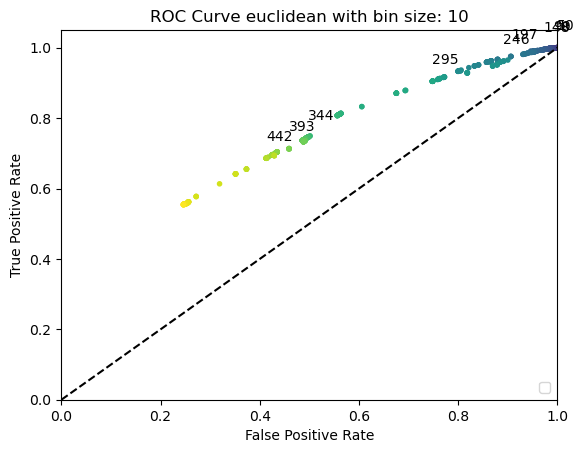

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


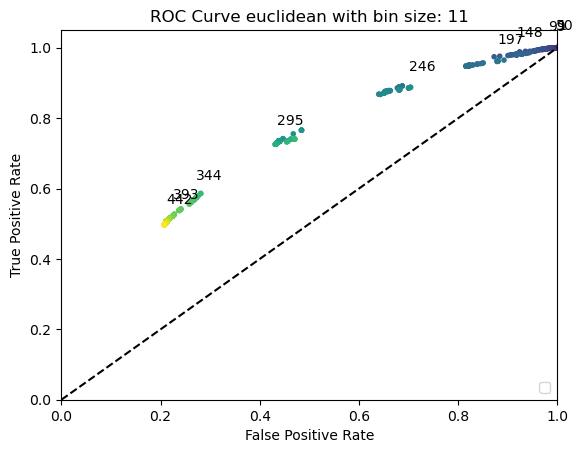

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


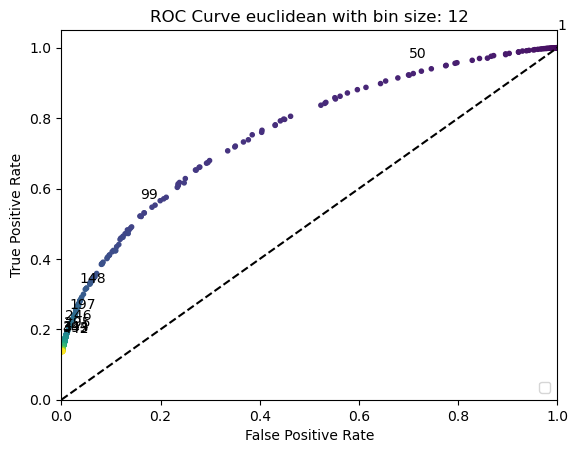

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


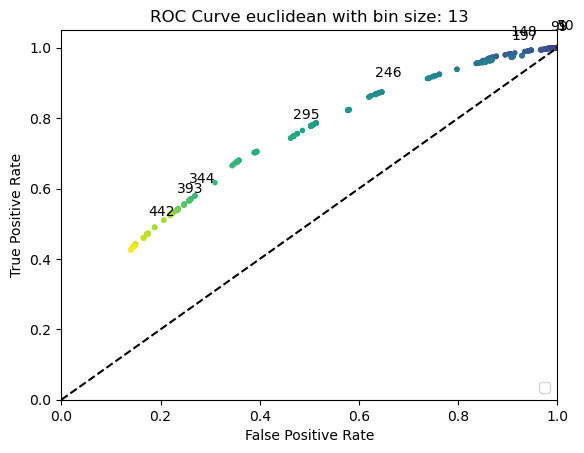

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


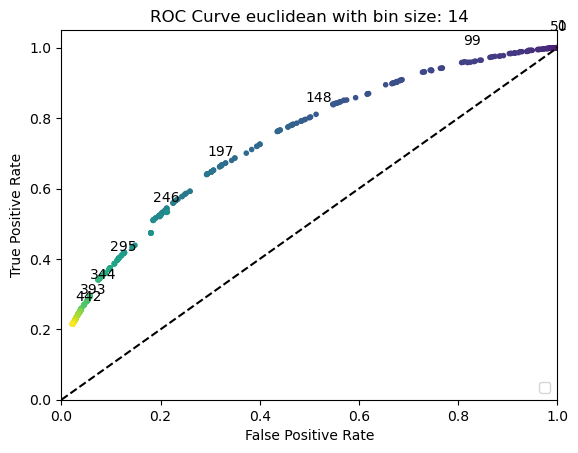

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


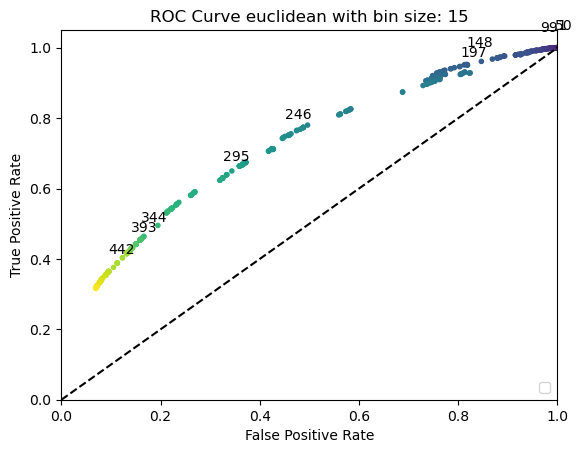

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


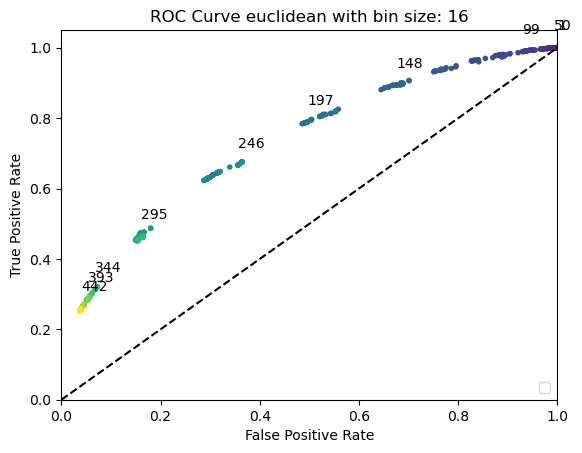

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


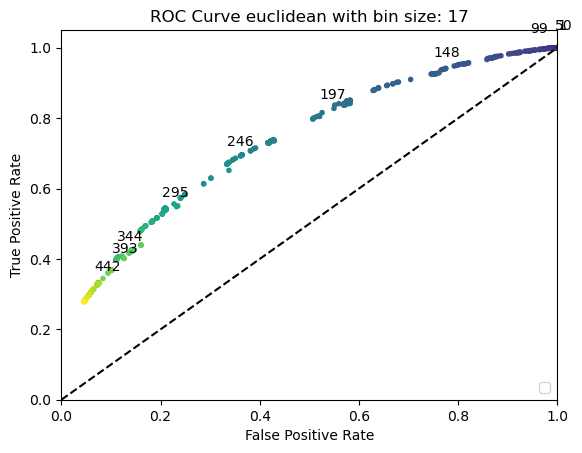

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


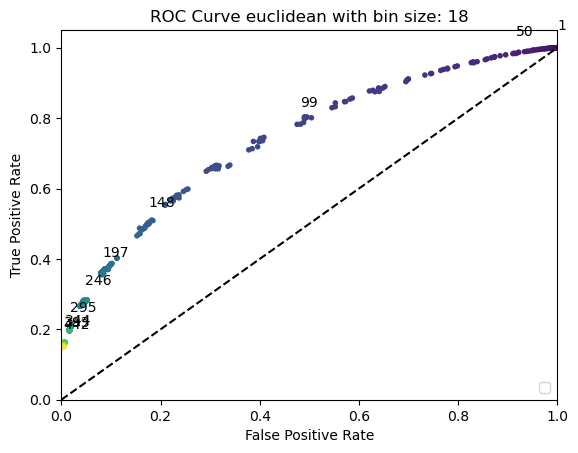

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


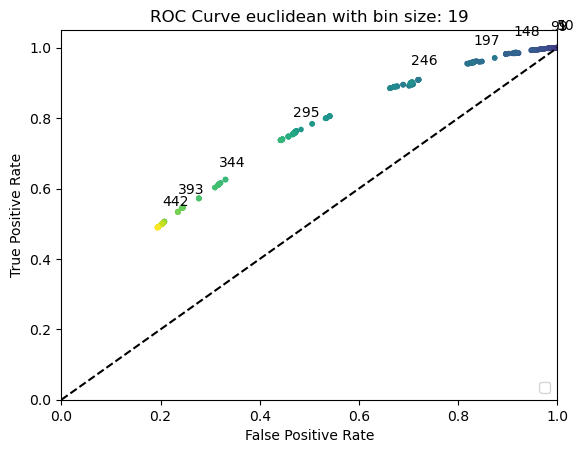

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


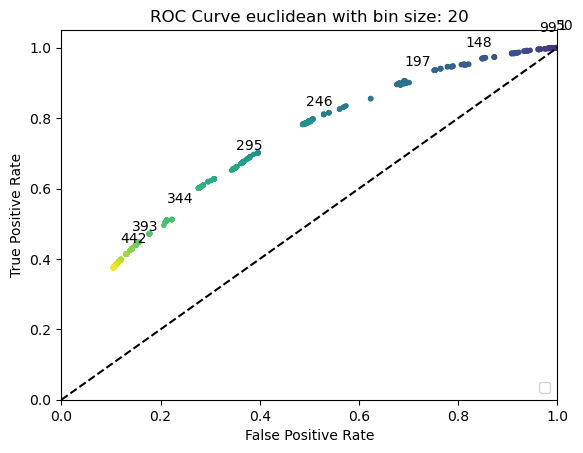

In [ ]:
for i, euclidean_df_binned in enumerate(euclidean_dfs_by_bin_size):
    plotROC(euclidean_df_binned, f"ROC Curve euclidean with bin size: {i+1}")

Need quantifiable metric to compare these curves

## Include Length Calculations

In [43]:
adjacency_length_dir = "../../../output/signatureMtxs_20bp/length/0,1"

euclidean_length_counts = parallel_regions(euclidean_signature_matrix_directory, include_length=adjacency_length_dir)
minHash_length_counts = parallel_regions(minHash_signature_matrix_directory, include_length=adjacency_length_dir)
sketch_length_counts = parallel_regions(sketch_signature_matrix_directory, include_length=adjacency_length_dir)

minHash_length_df = numpy_counts_to_pandas(minHash_length_counts)
euclidean_length_df = numpy_counts_to_pandas(euclidean_length_counts)
sketch_length_df = numpy_counts_to_pandas(sketch_length_counts)

Running Parallel Step


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.


[Parallel(n_jobs=128)]: Done 194 tasks      | elapsed:    3.1s
[Parallel(n_jobs=128)]: Done 544 tasks      | elapsed:    5.1s
[Parallel(n_jobs=128)]: Done 994 tasks      | elapsed:    7.7s
[Parallel(n_jobs=128)]: Done 1544 tasks      | elapsed:   10.7s
[Parallel(n_jobs=128)]: Done 2194 tasks      | elapsed:   14.3s
[Parallel(n_jobs=128)]: Done 2944 tasks      | elapsed:   18.7s
[Parallel(n_jobs=128)]: Done 3794 tasks      | elapsed:   23.6s
[Parallel(n_jobs=128)]: Done 4744 tasks      | elapsed:   28.9s
[Parallel(n_jobs=128)]: Done 5794 tasks      | elapsed:   34.9s
[Parallel(n_jobs=128)]: Done 6944 tasks      | elapsed:   41.4s
[Parallel(n_jobs=128)]: Done 8194 tasks      | elapsed:   48.6s
[Parallel(n_jobs=128)]: Done 9544 tasks      | elapsed:   56.4s
[Parallel(n_jobs=128)]: Done 10994 tasks      | elapsed:  1.1min
[Parallel(n_jobs=128)]: Done 12544 tasks      | elapsed:  1.2min
[Parallel(n_jobs=128)]: Done 14194 tasks      | elapsed:  1.4min
[Parallel(n_jobs=128)]: Done 15944 tasks

Total time	: 180.22083830833435
Running Parallel Step


[Parallel(n_jobs=128)]: Done 194 tasks      | elapsed:    1.2s
[Parallel(n_jobs=128)]: Done 832 tasks      | elapsed:    4.0s
[Parallel(n_jobs=128)]: Done 1378 tasks      | elapsed:    5.9s
[Parallel(n_jobs=128)]: Done 1928 tasks      | elapsed:    8.0s
[Parallel(n_jobs=128)]: Done 2578 tasks      | elapsed:   10.6s
[Parallel(n_jobs=128)]: Done 3328 tasks      | elapsed:   13.6s
[Parallel(n_jobs=128)]: Done 4178 tasks      | elapsed:   17.0s
[Parallel(n_jobs=128)]: Done 5128 tasks      | elapsed:   20.8s
[Parallel(n_jobs=128)]: Done 6178 tasks      | elapsed:   24.9s
[Parallel(n_jobs=128)]: Done 7328 tasks      | elapsed:   29.5s
[Parallel(n_jobs=128)]: Done 8578 tasks      | elapsed:   34.4s
[Parallel(n_jobs=128)]: Done 9928 tasks      | elapsed:   39.8s
[Parallel(n_jobs=128)]: Done 11378 tasks      | elapsed:   45.6s
[Parallel(n_jobs=128)]: Done 12928 tasks      | elapsed:   51.8s
[Parallel(n_jobs=128)]: Done 14578 tasks      | elapsed:   58.4s
[Parallel(n_jobs=128)]: Done 16328 task

Total time	: 124.20808577537537
Running Parallel Step


[Parallel(n_jobs=128)]: Done 194 tasks      | elapsed:    1.3s
[Parallel(n_jobs=128)]: Done 832 tasks      | elapsed:    4.1s
[Parallel(n_jobs=128)]: Done 1506 tasks      | elapsed:    6.6s
[Parallel(n_jobs=128)]: Done 2056 tasks      | elapsed:    8.8s
[Parallel(n_jobs=128)]: Done 2706 tasks      | elapsed:   11.5s
[Parallel(n_jobs=128)]: Done 3456 tasks      | elapsed:   14.6s
[Parallel(n_jobs=128)]: Done 4306 tasks      | elapsed:   18.0s
[Parallel(n_jobs=128)]: Done 5256 tasks      | elapsed:   21.9s
[Parallel(n_jobs=128)]: Done 6306 tasks      | elapsed:   26.2s
[Parallel(n_jobs=128)]: Done 7456 tasks      | elapsed:   30.8s
[Parallel(n_jobs=128)]: Done 8706 tasks      | elapsed:   36.0s
[Parallel(n_jobs=128)]: Done 10056 tasks      | elapsed:   41.5s
[Parallel(n_jobs=128)]: Done 11506 tasks      | elapsed:   47.5s
[Parallel(n_jobs=128)]: Done 13056 tasks      | elapsed:   53.8s
[Parallel(n_jobs=128)]: Done 14706 tasks      | elapsed:  1.0min
[Parallel(n_jobs=128)]: Done 16456 tas

Total time	: 127.65445590019226


[Parallel(n_jobs=128)]: Done 31093 out of 31093 | elapsed:  2.1min finished


In [52]:
minHash_length_df.head()

,true_pos,tot_pos,false_pos,tot_neg,tpr,fpr,band_size
0,2518209,2518218,2508062,2508234,0.999996,0.999931,1
1,2518031,2518218,2506270,2508234,0.999926,0.999217,2
2,2517149,2518218,2490840,2508234,0.999575,0.993065,3
3,2514740,2518218,2460457,2508234,0.998619,0.980952,4
4,2507009,2518218,2410985,2508234,0.995549,0.961228,5


In [53]:
minHash_df.head()

,true_pos,tot_pos,false_pos,tot_neg,tpr,fpr,band_size
0,2518209,2518218,2508062,2508234,0.999996,0.999931,1
1,2518031,2518218,2506270,2508234,0.999926,0.999217,2
2,2517149,2518218,2490840,2508234,0.999575,0.993065,3
3,2514740,2518218,2460457,2508234,0.998619,0.980952,4
4,2507009,2518218,2410985,2508234,0.995549,0.961228,5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


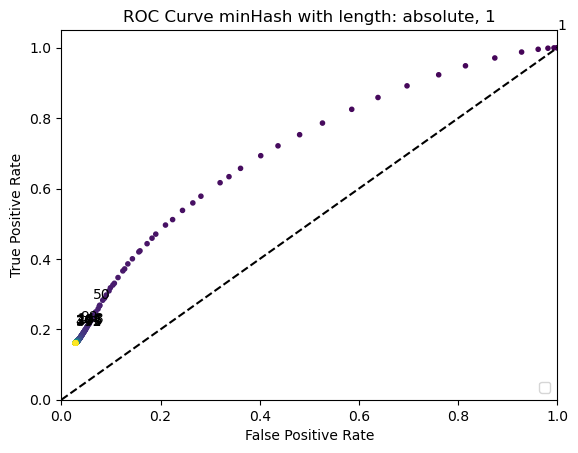

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


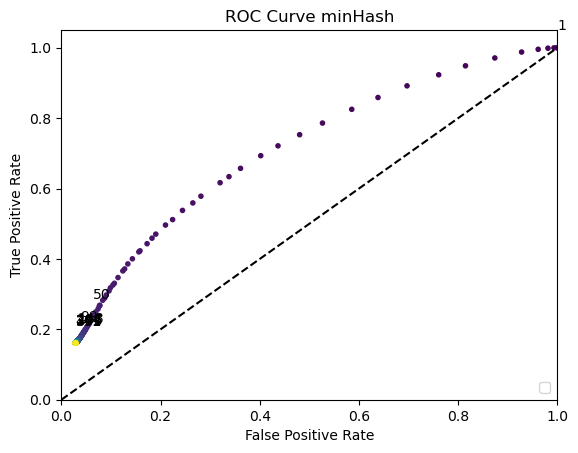

In [48]:
plotROC(minHash_length_df, f"ROC Curve minHash with length: absolute, 1")
plotROC(minHash_df, "ROC Curve minHash")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


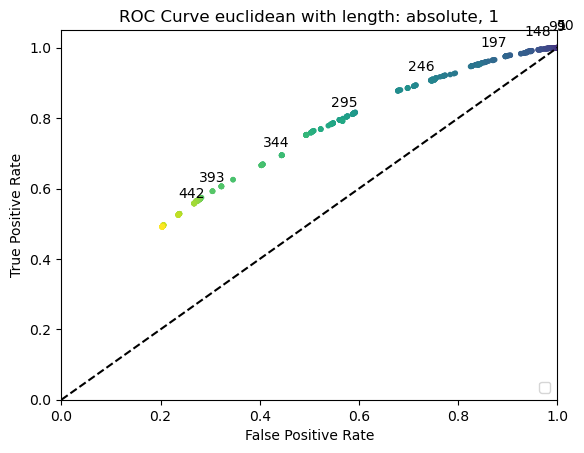

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


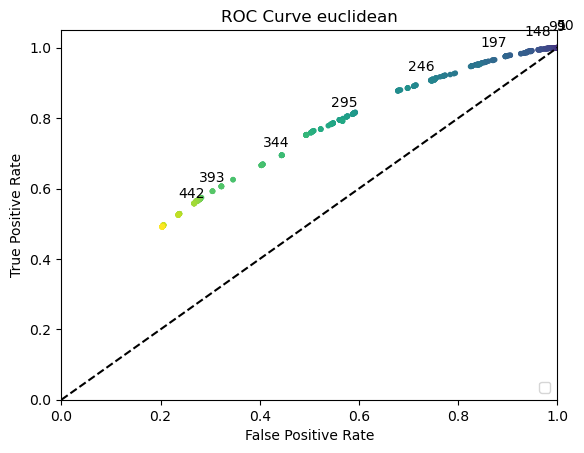

In [49]:
plotROC(euclidean_length_df, f"ROC Curve euclidean with length: absolute, 1")
plotROC(euclidean_df, "ROC Curve euclidean")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


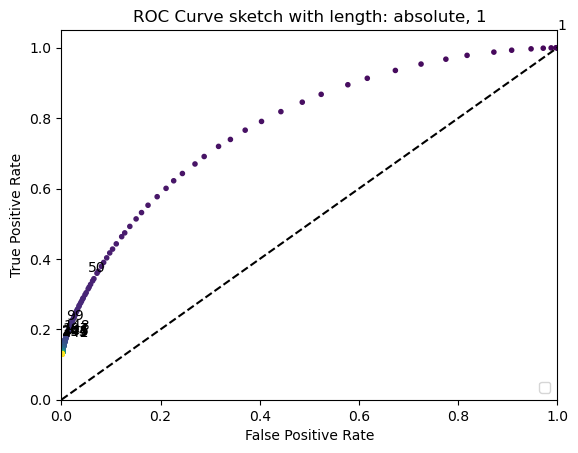

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


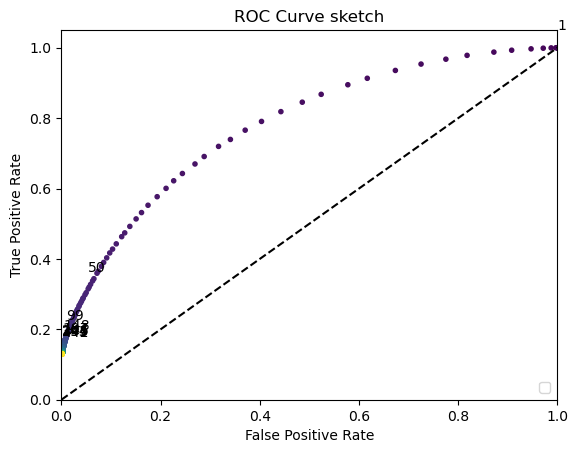

In [50]:
plotROC(sketch_length_df, f"ROC Curve sketch with length: absolute, 1")
plotROC(sketch_df, "ROC Curve sketch")

## Bug Fixing 2

In [14]:
euclidean_file = "/data/wford/sv_merge/output/signatureMtxs_20bp/euclidean/1000,21,1,1/chr1_337798-337903.npy"
a = np.load(euclidean_file)

In [18]:
a[20]

array([1041., 1041., 1041., 1041., 1041., 1041.])